<h3 align="center"><span class="badge"><b>Demo Notebook</b></span></h3>

<h1 align="center">LLM Steering</h1>

---

<h2 align="center">Materials for <a href="">https://iaetbibliotheques.fr/2026/01/le-steering-ou-comment-modifier-le-comportement-dun-llm-sans-fine-tuning</a></h2>

# 0.Requirements

In [ ]:
!uv pip install -U transformers huggingface_hub datasets accelerate

In [ ]:
from huggingface_hub import hf_hub_download
import torch
import torch
import torch.nn as nn
import json, tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer

/opt/python/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import gc
import torch

# Free up CUDA memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Run garbage collection
gc.collect()

0

In [ ]:
import torch
import transformers

print("PyTorch:")
print("PyTorch is working with CUDA" if torch.cuda.is_available() else "Error! It is not working correctly")
print("The GPU model is: "+ torch.cuda.get_device_name(0))

print(f"📦 PyTorch version: {torch.__version__}")
print(f"🤗 Transformers version: {transformers.__version__}")

PyTorch:
PyTorch is working with CUDA
The GPU model is: NVIDIA A2
📦 PyTorch version: 2.9.1+cu128
🤗 Transformers version: 4.57.3


In [ ]:
from huggingface_hub import login
login(token="...")

In [ ]:
model_id = "meta-llama/Llama-3.2-3B-Instruct"
dtype=torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16

print(f"Loading {model_id}...")

device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    dtype=dtype,
    device_map=device
)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

Loading meta-llama/Llama-3.2-3B-Instruct...


Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]


In [ ]:
model.config

LlamaConfig {
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "dtype": "bfloat16",
  "eos_token_id": [
    128001,
    128008,
    128009
  ],
  "head_dim": 128,
  "hidden_act": "silu",
  "hidden_size": 3072,
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 24,
  "num_hidden_layers": 28,
  "num_key_value_heads": 8,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": {
    "factor": 32.0,
    "high_freq_factor": 4.0,
    "low_freq_factor": 1.0,
    "original_max_position_embeddings": 8192,
    "rope_type": "llama3"
  },
  "rope_theta": 500000.0,
  "tie_word_embeddings": true,
  "transformers_version": "4.57.3",
  "use_cache": true,
  "vocab_size": 128256
}

# 1.On shot pure steering

In [ ]:
# ------------------------------------------------------------------
# 2.  Tiny corpora (100+ prompts per class)
# ------------------------------------------------------------------

plain_prompts = [
    "Explain what a black hole is.",
    "Tell me how rainbows form.",
    "Why do we sleep?",
    "How do vaccines work?",
    "What causes earthquakes?",
    "Explain how a plane stays in the air.",
    "Why is the sky blue?",
    "How do batteries store energy?",
    "What is DNA?",
    "How do plants make food?",
    "What is climate change?",
    "Why do we have seasons?",
    "What is an atom?",
    "How does a microwave heat food?",
    "Why do we get fevers?",
    "How does the internet work?",
    "What is gravity?",
    "Why does ice float?",
    "How do magnets work?",
    "What makes something radioactive?",
    "Explain what photosynthesis is.",
    "How does a telescope help us see far away things?",
    "What are hormones?",
    "Why do we yawn?",
    "How do antibiotics work?",
    "What is a virus?",
    "How does the heart pump blood?",
    "Why do we dream?",
    "What is electricity?",
    "How do satellites stay in space?",
    "What is a gene?",
    "How does a computer store information?",
    "Why do metals conduct electricity?",
    "What is a fossil?",
    "How do clouds form?",
    "What makes a tornado?",
    "Why does salt melt ice?",
    "How do fish breathe underwater?",
    "Why do leaves change color?",
    "What causes tides?",
    "How do muscles grow?",
    "Why do we hiccup?",
    "What is evolution?",
    "How do lasers work?",
    "Why do we have fingerprints?",
    "How does the liver work?",
    "What is a neuron?",
    "How do we smell things?",
    "Why do we get allergies?",
    "How do earthquakes create tsunamis?",
    "What is the greenhouse effect?",
    "Why do we blush?",
    "How does a refrigerator keep food cold?",
    "What is a coma?",
    "How do we measure time?",
    "Why do we have different blood types?",
    "How do bridges stay up?",
    "Why do stars twinkle?",
    "What is a galaxy?",
    "How do solar panels work?",
    "Why do we get jet lag?",
    "How do sharks sense things?",
    "What is the immune system?",
    "How do kidneys clean blood?",
    "Why do we have menopause?",
    "How do earthquakes get detected?",
    "What is a black hole made of?",
    "How do we hear sounds?",
    "Why do things rust?",
    "What causes lightning?",
    "How does a touch screen work?",
    "Why do we need water to live?",
    "How do we see color?",
    "What is a pandemic?",
    "Why do some people get motion sickness?",
    "How do you get energy from food?",
    "What is a solar eclipse?",
    "Why do cats purr?",
    "How does the brain control the body?",
    "What is cholesterol?",
    "Why do we have emotions?",
    "How do you make glass?",
    "Why do some things glow in the dark?",
    "How does GPS find your location?",
    "What is a supernova?",
    "Why do we get headaches?",
    "How do deserts form?",
    "What is a microorganism?",
    "Why do we need sunlight?",
    "How do spiders make webs?",
    "What is a cell?",
    "Why do we have different kinds of clouds?",
    "How does a compass point north?",
    "Why do some metals bend and others break?",
    "How do bubbles form in boiling water?",
    "What is a concussion?",
    "Why do we have an appendix?",
    "How does a volcano erupt?",
    "Why do we get sunburned?",
    "How do glaciers move?",
    "What is a placebo?",
    "Why do people snore?",
    "How does caffeine keep you awake?",
    "What is the ozone layer?",
    "Why do we have nightmares?",
    "How do we learn new things?",
]

academic_prompts = [
    "Provide a concise scientific overview of black-hole formation and key properties in general relativity.",
    "Explain the optical physics underlying rainbow formation, including refraction, dispersion, and internal reflection.",
    "Summarise current neurobiological theories regarding the functions of human sleep and their empirical support.",
    "Describe the immunological mechanisms of vaccination, including antigen presentation, memory formation, and herd effects.",
    "Discuss the tectonophysical processes that generate earthquakes and the primary determinants of rupture magnitude.",
    "Analyse the aerodynamic principles enabling fixed-wing flight, emphasising lift generation and boundary-layer behaviour.",
    "Explain Rayleigh scattering as the principal mechanism of sky colouration and note conditions where Mie scattering dominates.",
    "Describe electrochemical energy storage in batteries, contrasting ion-transport and electrode reaction kinetics across chemistries.",
    "Provide an overview of DNA structure and its role in heredity, including replication fidelity and mutation processes.",
    "Explain photosynthetic energy transduction, detailing light harvesting, electron transport, and carbon fixation pathways.",
    "Discuss the physical basis and observational evidence for contemporary climate change, including attribution of anthropogenic forcing.",
    "Explain Earth’s seasonal cycle in terms of axial tilt, solar insolation geometry, and hemispheric radiative balance.",
    "Provide a foundational description of atomic structure, including quantum states, electron shells, and binding energies.",
    "Explain dielectric heating in microwave ovens, focusing on dipole rotation, loss tangent, and penetration depth effects.",
    "Describe the pathophysiology of fever, including cytokine signalling, hypothalamic set-point modulation, and adaptive trade-offs.",
    "Provide a systems-level description of internet architecture, including packet switching, routing protocols, and latency constraints.",
    "Explain gravitation within Newtonian and relativistic frameworks, noting regimes where each approximation is valid.",
    "Analyse the thermodynamic and structural reasons ice exhibits lower density than liquid water, including hydrogen bonding effects.",
    "Describe the physical basis of magnetism in materials, from electron spin to domain formation and hysteresis behaviour.",
    "Explain the origin of radioactivity via nuclear instability, and distinguish alpha, beta, and gamma decay mechanisms.",
    "Provide a concise definition of photosynthesis and discuss its ecological significance for global carbon and oxygen cycles.",
    "Discuss how telescopes improve angular resolution and sensitivity, referencing aperture, diffraction limits, and detector noise.",
    "Provide an overview of endocrine hormones, their receptor-mediated signalling, and homeostatic feedback regulation.",
    "Discuss yawning from physiological and comparative perspectives, outlining leading hypotheses and evidentiary limitations.",
    "Explain antibiotic modes of action and mechanisms of antimicrobial resistance, including selection dynamics and horizontal transfer.",
    "Define viruses in terms of replication strategy and host dependence, contrasting major genome classes and infection cycles.",
    "Describe cardiac hemodynamics and electrical conduction underlying blood circulation, including key phases of the cardiac cycle.",
    "Summarise contemporary theories of dreaming, including REM-associated neural activity and competing functional accounts.",
    "Provide a concise account of electricity as charge transport, including field concepts, potential difference, and circuit behaviour.",
    "Explain orbital mechanics governing satellite motion, including gravitational balance, perturbations, and station-keeping strategies.",
    "Define the concept of a gene in modern genomics, including regulatory elements, splicing, and non-coding functional regions.",
    "Describe digital information storage principles in computers, including binary encoding, memory hierarchies, and error correction.",
    "Explain electron transport in metals using band theory, and contrast conduction with semiconductors and insulators.",
    "Discuss fossil formation processes (taphonomy) and the inferential limits of the fossil record for reconstructing past ecosystems.",
    "Explain cloud formation via atmospheric thermodynamics, including adiabatic cooling, condensation nuclei, and phase transitions.",
    "Analyse the mesoscale atmospheric dynamics conducive to tornado genesis, referencing wind shear, supercells, and vortices.",
    "Explain freezing-point depression in saline solutions and its practical implications for ice melting and de-icing.",
    "Describe respiratory adaptations enabling fish gill gas exchange, including countercurrent flow and diffusion constraints.",
    "Explain the biochemical and ecological drivers of autumn leaf colour change, including chlorophyll breakdown and anthocyanin roles.",
    "Discuss tidal forcing in the Earth–Moon–Sun system, including gravitational gradients and ocean basin resonance effects.",
    "Describe muscle hypertrophy mechanisms, including mechanical tension, protein synthesis signalling, and training variables.",
    "Discuss proposed mechanisms of hiccups (singultus), including reflex arcs and clinical associations, noting unresolved questions.",
    "Provide an overview of evolution by natural selection, including variation, inheritance, and population-level change.",
    "Explain laser operation principles, including stimulated emission, population inversion, cavity resonance, and coherence.",
    "Discuss the biological basis of fingerprints, including developmental formation and proposed functional significance.",
    "Describe hepatic physiology and metabolic functions of the liver, including detoxification pathways and bile production.",
    "Provide a concise overview of neurons, including membrane excitability, synaptic transmission, and network computation.",
    "Explain olfaction mechanisms, including receptor binding, signal transduction, and central processing of odour perception.",
    "Discuss immunological mechanisms of allergy, including IgE-mediated responses, sensitisation, and common interventions.",
    "Analyse tsunami generation from seismic events, focusing on seafloor displacement, wave propagation, and coastal amplification.",
    "Explain the greenhouse effect in radiative-transfer terms, including absorption spectra and feedback processes.",
    "Discuss blushing as an autonomic response, including sympathetic activation and psychosocial triggers, with reference to evidence.",
    "Explain refrigeration cycles thermodynamically, including compression, expansion, heat exchange, and coefficient of performance.",
    "Provide an overview of coma aetiologies and neurophysiological correlates, distinguishing structural from metabolic causes.",
    "Discuss the measurement of time, including periodic standards, atomic clocks, and sources of systematic error.",
    "Explain the genetic and immunological basis of ABO blood groups and their clinical relevance for transfusion compatibility.",
    "Analyse structural engineering principles ensuring bridge stability, including load paths, materials, and failure modes.",
    "Explain stellar scintillation (twinkling) as an atmospheric turbulence phenomenon and relate it to seeing conditions in astronomy.",
    "Provide an overview of galaxies, including morphology, stellar populations, and evidence for dark matter halos.",
    "Explain photovoltaic energy conversion in solar cells, including band gaps, charge separation, and efficiency limits.",
    "Discuss circadian rhythm disruption underlying jet lag, including zeitgebers and phase-reset dynamics.",
    "Describe sensory modalities in sharks, including electroreception, mechanoreception, and olfaction, and their ecological roles.",
    "Provide an overview of the immune system, distinguishing innate and adaptive components and key effector mechanisms.",
    "Explain renal filtration and reabsorption processes in kidneys, including glomerular function and hormonal regulation.",
    "Discuss menopause endocrinologically, including ovarian follicle depletion, hormonal changes, and health implications.",
    "Describe modern earthquake detection and localisation methods, including seismometer networks and waveform inversion.",
    "Discuss the physical interpretation of black holes (e.g., horizons and singularities) within general relativity and open questions.",
    "Explain auditory transduction, including cochlear mechanics, hair-cell signalling, and neural encoding of sound frequency.",
    "Explain rust formation as electrochemical corrosion, including redox reactions and environmental factors influencing rates.",
    "Describe lightning formation mechanisms, including charge separation in storms, breakdown processes, and discharge channels.",
    "Explain capacitive touch-screen sensing, including mutual capacitance, signal processing, and noise considerations.",
    "Discuss physiological roles of water in humans, including solvent properties, thermoregulation, and homeostatic regulation.",
    "Explain colour vision, including cone photoreceptors, opponent processing, and perceptual phenomena such as metamerism.",
    "Define pandemics epidemiologically and discuss key parameters (R0, generation time) that govern global spread.",
    "Discuss motion sickness in terms of sensory conflict theory and vestibular physiology, noting individual variability factors.",
    "Explain metabolic energy extraction from food, including digestion, cellular respiration, and ATP yield regulation.",
    "Explain solar eclipses geometrically, including umbra/penumbra formation and orbital alignment constraints.",
    "Discuss purring in domestic cats, outlining proposed mechanisms and hypothesised functional roles with evidentiary caveats.",
    "Explain how the brain controls the body via motor pathways, including cortical planning, spinal circuits, and feedback control.",
    "Provide an overview of cholesterol metabolism and transport, including lipoproteins and implications for cardiovascular risk.",
    "Discuss leading theories of emotion, including appraisal, constructionist, and neurobiological perspectives, and methodological debates.",
    "Describe industrial glass production at a high level, including silica-based composition, melting, forming, and annealing steps.",
    "Explain photoluminescence mechanisms underlying glow-in-the-dark materials, including excitation, traps, and emission spectra.",
    "Describe GPS positioning, including trilateration, clock synchronisation, error sources, and augmentation systems.",
    "Provide an overview of supernova mechanisms, contrasting core-collapse and thermonuclear pathways and nucleosynthesis outcomes.",
    "Discuss headache pathophysiology, including vascular, neural, and inflammatory mechanisms, and common clinical classifications.",
    "Explain desert formation and maintenance, including atmospheric circulation patterns, rain shadows, and land–atmosphere feedbacks.",
    "Define microorganisms broadly and discuss their roles in ecology, disease, and biogeochemical cycles.",
    "Discuss the role of sunlight in biological systems, including vitamin D synthesis and circadian entrainment, and photobiological risks.",
    "Explain spider silk production and web construction behaviour, including material properties and evolutionary drivers.",
    "Provide a concise overview of the cell as a biological unit, including membranes, organelles, and gene expression control.",
    "Discuss cloud classification and formation processes, relating morphology to atmospheric stability and moisture profiles.",
    "Explain how compasses align with Earth’s magnetic field, including magnetic declination and local anomalies.",
    "Discuss mechanical properties of metals (ductility vs brittleness) in terms of microstructure, dislocations, and temperature effects.",
    "Explain bubble nucleation during boiling, including vapour pressure, nucleation sites, and heat flux dependence.",
    "Provide an overview of concussion mechanisms and neurocognitive effects, including acute management considerations.",
    "Discuss hypothesised functions of the appendix and evaluate current evidence for immunological or microbiome-related roles.",
    "Explain volcanic eruptions in terms of magma rheology, volatile exsolution, and tectonic setting, contrasting eruption styles.",
    "Discuss the mechanisms of sunburn, including UV-induced DNA damage, inflammation, and photoprotection strategies.",
    "Explain glacier dynamics, including mass balance, basal sliding, and responses to climatic forcing.",
    "Define the placebo effect and discuss underlying mechanisms, including expectation, conditioning, and measurement challenges in trials.",
    "Discuss snoring biomechanics, including upper-airway resistance, sleep stage effects, and clinical relevance for sleep apnoea.",
    "Explain caffeine pharmacodynamics and pharmacokinetics relevant to alertness, including adenosine receptor antagonism and half-life.",
    "Provide an overview of the ozone layer, including stratospheric chemistry and the role of ozone in UV attenuation.",
    "Discuss nightmares in relation to sleep architecture and psychopathology, and summarise evidence-based interventions.",
    "Discuss mechanisms of learning and memory, including synaptic plasticity, consolidation, and factors affecting retention.",
]


In [ ]:
LAYER = 15
activations = {}   # cache

def _get_inputs_device(model):
    # With device_map="auto", there isn't a single model.device.
    # This picks a stable device (usually where embeddings live).
    try:
        return model.model.embed_tokens.weight.device
    except Exception:
        return next(model.parameters()).device

def make_hook(layer_idx):
    def hook(module, inp, out):
        # HF LlamaDecoderLayer typically returns a Tensor (B,T,D)
        # but sometimes returns a tuple where out[0] is the hidden states.
        hs = out[0] if isinstance(out, (tuple, list)) else out

        # hs should now be (B, T, D). If (T, D), re-add batch dim.
        if hs.dim() == 2:
            hs = hs.unsqueeze(0)

        activations[layer_idx] = hs.detach().float()
    return hook

@torch.no_grad()
def get_vector_chat(prompts, desc, max_length=256, system_prompt=None):
    """
    prompts: list[str] where each string is the user content.
    Computes mean last-token activation at layer LAYER using chat template.
    """
    handle = model.model.layers[LAYER].register_forward_hook(make_hook(LAYER))
    vecs = []
    device = _get_inputs_device(model)

    for p in tqdm.tqdm(prompts, desc=desc):
        #messages = [{"role": "user", "content": p}]
        messages = []
        if system_prompt:
            messages.append({"role": "system", "content": system_prompt})
        messages.append({"role": "user", "content": p})

        inputs = tokenizer.apply_chat_template(
            messages,
            tokenize=True,
            add_generation_prompt=True,
            return_tensors="pt",
            return_dict=True,
            truncation=True,
            max_length=max_length,
        )
        inputs = {k: v.to(device) for k, v in inputs.items()}

        activations.pop(LAYER, None)
        _ = model(**inputs)

        last_hidden = activations[LAYER]     # (B, T, D)
        last_token  = last_hidden[0, -1, :]  # (D,)
        vecs.append(last_token.cpu())

    handle.remove()
    return torch.stack(vecs).mean(0)

## 1.1 Without system prompt

In [ ]:
# ------------------------------------------------------------------
# 4.  Compute difference-of-means vector
# ------------------------------------------------------------------
#steering_vec = (v_academic - v_plain)
#steering_vec = steering_vec / (steering_vec.norm() + 1e-12)

v_plain    = get_vector_chat(plain_prompts,    "Plain")
v_academic = get_vector_chat(academic_prompts, "Academic")
steering_vec = (v_academic - v_plain).to(device)
steering_vec = steering_vec / steering_vec.norm()     # unit vector

print("Steering vector shape:", steering_vec.shape)

Academic: 100%|██████████| 106/106 [00:20<00:00,  5.13it/s]


Steering vector shape: torch.Size([3072])


In [ ]:
coeff = 8
INJECT_LAST_TOKEN_ONLY = False  # try True first for "style"

def steering_hook(module, inp, out):
    # 1) get hidden states tensor hs: (B, T, D)
    hs = out[0] if isinstance(out, (tuple, list)) else out

    if hs.dim() == 2:
        hs = hs.unsqueeze(0)  # (1, T, D) just in case

    v = steering_vec.to(device=hs.device, dtype=hs.dtype)

    # 2) apply steering
    if INJECT_LAST_TOKEN_ONLY:
        hs2 = hs.clone()
        hs2[:, -1, :] = hs2[:, -1, :] + coeff * v
    else:
        hs2 = hs + coeff * v  # broadcasts over (B,T)

    # 3) return same type as original output
    if isinstance(out, (tuple, list)):
        return (hs2,) + tuple(out[1:])
    else:
        return hs2

handle = model.model.layers[LAYER].mlp.register_forward_hook(steering_hook)

In [ ]:
# ------------------------------------------------------------------
# 6.  Quick test
# ------------------------------------------------------------------
def generate(text, max_length=256, max_new=256):
    message = [{"role": "user", "content": text}]
    inputs = tokenizer.apply_chat_template(
            message,
            tokenize=True,
            add_generation_prompt=True,
            return_tensors="pt",
            return_dict=True,
            truncation=True,
            max_length=max_length,
        ).to(device)
    with torch.no_grad():
        out = model.generate(
                **inputs,
                max_new_tokens=max_new,
                do_sample=False,
                pad_token_id=tokenizer.eos_token_id
             )
    return tokenizer.decode(out[0], skip_special_tokens=True)

print("----- WITHOUT steering (remove hook first) -----")
handle.remove()
print(generate("Explain what a black hole is."))
print("\n----- WITH steering -----")
handle = model.model.layers[LAYER].mlp.register_forward_hook(steering_hook)
print(generate("Explain what a black hole is."))
handle.remove()

----- WITHOUT steering (remove hook first) -----
system

Cutting Knowledge Date: December 2023
Today Date: 08 Jan 2026

user

Explain what a black hole is.assistant

A black hole is a region in space where the gravitational pull is so strong that nothing, including light, can escape. It is formed when a massive star collapses in on itself and its gravity becomes so strong that it warps the fabric of spacetime around it.

Here's a step-by-step explanation of how a black hole is formed:

1. **Massive star collapse**: A massive star runs out of fuel and dies. If the star is massive enough (about 3-4 times the size of the sun), its gravity collapses the star in on itself.
2. **Supernova explosion**: The star collapses, causing a massive explosion known as a supernova. This explosion expels a large amount of matter into space.
3. **Core collapse**: The core of the star collapses into a singularity, a point of infinite density and zero volume. This singularity is the center of the black hole

## 1.2 With system prompt

In [ ]:
SYSTEM_PROMPT = (
    "You are an academic researcher. "
    "You answer in a rigorous, precise, and scientific manner."
)

# ------------------------------------------------------------------
# 4.  Compute difference-of-means vector
# ------------------------------------------------------------------
#steering_vec = (v_academic - v_plain)
#steering_vec = steering_vec / (steering_vec.norm() + 1e-12)

v_plain    = get_vector_chat(plain_prompts,    "Plain")
v_academic = get_vector_chat(academic_prompts, "Academic", system_prompt=SYSTEM_PROMPT)
steering_vec = (v_academic - v_plain).to(device)
steering_vec = steering_vec / steering_vec.norm()     # unit vector

print("Steering vector shape:", steering_vec.shape)

Academic: 100%|██████████| 106/106 [00:07<00:00, 14.57it/s]

Steering vector shape: torch.Size([3072])


In [ ]:
coeff = 8
INJECT_LAST_TOKEN_ONLY = False  # try True first for "style"

def steering_hook(module, inp, out):
    # 1) get hidden states tensor hs: (B, T, D)
    hs = out[0] if isinstance(out, (tuple, list)) else out

    if hs.dim() == 2:
        hs = hs.unsqueeze(0)  # (1, T, D) just in case

    v = steering_vec.to(device=hs.device, dtype=hs.dtype)

    # 2) apply steering
    if INJECT_LAST_TOKEN_ONLY:
        hs2 = hs.clone()
        hs2[:, -1, :] = hs2[:, -1, :] + coeff * v
    else:
        hs2 = hs + coeff * v  # broadcasts over (B,T)

    # 3) return same type as original output
    if isinstance(out, (tuple, list)):
        return (hs2,) + tuple(out[1:])
    else:
        return hs2

handle = model.model.layers[LAYER].mlp.register_forward_hook(steering_hook)

In [ ]:
# ------------------------------------------------------------------
# 6.  Quick test
# ------------------------------------------------------------------
def generate(text, max_length=256, max_new=256):
    message = [{"role": "user", "content": text}]
    inputs = tokenizer.apply_chat_template(
            message,
            tokenize=True,
            add_generation_prompt=True,
            return_tensors="pt",
            return_dict=True,
            truncation=True,
            max_length=max_length,
        ).to(device)
    with torch.no_grad():
        out = model.generate(
                **inputs,
                max_new_tokens=max_new,
                do_sample=False,
                pad_token_id=tokenizer.eos_token_id
             )
    return tokenizer.decode(out[0], skip_special_tokens=True)

print("----- WITHOUT steering (remove hook first) -----")
handle.remove()
print(generate("Explain what a black hole is."))
print("\n----- WITH steering -----")
handle = model.model.layers[LAYER].mlp.register_forward_hook(steering_hook)
print(generate("Explain what a black hole is."))
handle.remove()

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


----- WITHOUT steering (remove hook first) -----
system

Cutting Knowledge Date: December 2023
Today Date: 08 Jan 2026

user

Explain what a black hole is.assistant

A black hole is a region in space where the gravitational pull is so strong that nothing, including light, can escape. It is formed when a massive star collapses in on itself and its gravity becomes so strong that it warps the fabric of spacetime around it.

Here's a step-by-step explanation of how a black hole is formed:

1. **Massive star collapse**: A massive star runs out of fuel and dies. If the star is massive enough (about 3-4 times the size of the sun), its gravity collapses the star in on itself.
2. **Supernova explosion**: The star collapses, causing a massive explosion known as a supernova. This explosion expels a large amount of matter into space.
3. **Core collapse**: The core of the star collapses into a singularity, a point of infinite density and zero volume. This singularity is the center of the black hole

# 2.Systematic steering + evaluation

## 2.1 Systematic steering at different layers with different coefficients

In [ ]:
import re
import torch
import pandas as pd
import tqdm
from collections import Counter
from contextlib import contextmanager

# -------------------------
# Utilities
# -------------------------

def _get_inputs_device(model):
    # With device_map="auto", use embedding device as a stable "input" device
    try:
        return model.model.embed_tokens.weight.device
    except Exception:
        return next(model.parameters()).device

def _build_chat_inputs(tokenizer, user_prompt, device, max_length=256, system_prompt=None):
    messages = []
    if system_prompt:
        messages.append({"role": "system", "content": system_prompt})
    messages.append({"role": "user", "content": user_prompt})

    inputs = tokenizer.apply_chat_template(
        messages,
        tokenize=True,
        add_generation_prompt=True,
        return_tensors="pt",
        return_dict=True,
        truncation=True,
        max_length=max_length,
    )
    return {k: v.to(device) for k, v in inputs.items()}

def _decode_new_tokens(tokenizer, out_ids, prompt_len):
    # out_ids: (1, total_len)
    new_ids = out_ids[0, prompt_len:]
    return tokenizer.decode(new_ids, skip_special_tokens=True)

SYSTEM_PROMPT = (
    "You are an academic researcher. "
    "You answer in a rigorous, precise, and scientific manner."
)

# -------------------------
# Activation capture for DoM
# -------------------------

def make_capture_hook(cache, layer_idx):
    def hook(module, inp, out):
        hs = out[0] if isinstance(out, (tuple, list)) else out  # (B,T,D) usually
        if hs.dim() == 2:
            hs = hs.unsqueeze(0)  # (1,T,D) just in case
        cache[layer_idx] = hs.detach().float()
    return hook

@torch.no_grad()
def get_dom_vector_for_layer(
    model, tokenizer, layer_idx,
    plain_prompts, academic_prompts,
    max_length=256,
    system_prompt=None,
):
    """
    Returns normalized steering vector v = mean(h_academic_last) - mean(h_plain_last)
    measured at layer 'layer_idx' with chat template.
    """
    cache = {}
    #device = _get_inputs_device(model)

    handle = model.model.layers[layer_idx].register_forward_hook(make_capture_hook(cache, layer_idx))

    def mean_last_token(prompts, desc, system_prompt=None):
        vecs = []
        for p in tqdm.tqdm(prompts, desc=desc):
            inputs = _build_chat_inputs(tokenizer, p, device, max_length=max_length, system_prompt=system_prompt)
            cache.pop(layer_idx, None)
            _ = model(**inputs)
            hs = cache[layer_idx]           # (B,T,D)
            vecs.append(hs[0, -1, :].cpu()) # last token of prompt
        return torch.stack(vecs).mean(0)

    v_plain = mean_last_token(plain_prompts,    f"DoM Plain (L{layer_idx})")
    v_acad  = mean_last_token(academic_prompts, f"DoM Acad  (L{layer_idx})", system_prompt=SYSTEM_PROMPT)

    handle.remove()

    v = (v_acad - v_plain).to(device)
    v = v / v.norm()
    return v

# -------------------------
# Steering hook (robust)
# -------------------------

def make_steering_hook(steering_vec, coeff=0.8, inject_last_token_only=True):
    def hook(module, inp, out):
        hs = out[0] if isinstance(out, (tuple, list)) else out
        if hs.dim() == 2:
            hs = hs.unsqueeze(0)

        v = steering_vec.to(device=hs.device, dtype=hs.dtype)

        if inject_last_token_only:
            hs2 = hs.clone()
            hs2[:, -1, :] = hs2[:, -1, :] + coeff * v
        else:
            hs2 = hs + coeff * v  # broadcasts over (B,T)

        if isinstance(out, (tuple, list)):
            return (hs2,) + tuple(out[1:])
        else:
            return hs2
    return hook

@contextmanager
def steering_context(model, layer_idx, steering_vec, coeff=0.8, inject_last_token_only=True):
    hook_fn = make_steering_hook(steering_vec, coeff=coeff, inject_last_token_only=inject_last_token_only)
    handle = model.model.layers[layer_idx].register_forward_hook(hook_fn)
    try:
        yield
    finally:
        handle.remove()

# -------------------------
# Generation runner
# -------------------------

@torch.no_grad()
def generate_answer(
    model, tokenizer, prompt,
    max_new_tokens=200,
    max_length=256,
    do_sample=False,
    system_prompt=None,
):
    #device = _get_inputs_device(model)
    inputs = _build_chat_inputs(tokenizer, prompt, device, max_length=max_length, system_prompt=system_prompt)
    prompt_len = inputs["input_ids"].shape[1]

    out_ids = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        do_sample=do_sample,
        pad_token_id=tokenizer.eos_token_id,
    )
    return _decode_new_tokens(tokenizer, out_ids, prompt_len)

def sweep_layers_and_coeffs(
    model, tokenizer,
    plain_prompts, academic_prompts,
    eval_prompts,
    layers=(4, 8, 12, 15, 18, 22, 26),
    coeffs=(3, 6, 9, 12),
    inject_last_token_only=True,
    dom_max_length=256,
    gen_max_length=256,
    max_new_tokens=200,
    system_prompt=None,
):
    rows = []

    # Baseline (no steering) once per eval prompt
    baseline = {}
    for ep in tqdm.tqdm(eval_prompts, desc="Baseline (no steering)"):
        ans = generate_answer(
            model, tokenizer, ep,
            max_new_tokens=max_new_tokens,
            max_length=gen_max_length,
            system_prompt=system_prompt,
        )
        baseline[ep] = ans

    for layer in layers:
        v = get_dom_vector_for_layer(
            model, tokenizer, layer,
            plain_prompts, academic_prompts,
            max_length=dom_max_length,
            system_prompt=system_prompt,
        )

        for coeff in coeffs:
            for ep in tqdm.tqdm(eval_prompts, desc=f"Gen L{layer} coeff={coeff}"):
                with steering_context(model, layer, v, coeff=coeff, inject_last_token_only=inject_last_token_only):
                    steered = generate_answer(
                        model, tokenizer, ep,
                        max_new_tokens=max_new_tokens,
                        max_length=gen_max_length,
                        system_prompt=system_prompt,
                    )

                base = baseline[ep]
                bsc = academic_style_score(base)
                ssc = academic_style_score(steered)

                rows.append({
                    "layer": layer,
                    "coeff": coeff,
                    "prompt": ep,

                    "baseline": base,
                    "steered": steered,
                })

    df = pd.DataFrame(rows)
    return df

In [ ]:
model_id = "meta-llama/Llama-3.2-3B-Instruct"
dtype=torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16

print(f"Loading {model_id}...")
# We load in float16 to save memory, map to GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    dtype=dtype,
    device_map=device
)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

Loading meta-llama/Llama-3.2-3B-Instruct...


Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


In [ ]:
eval_prompts = [
    "Explain why the sky is blue.",
    "What is overfitting in machine learning?",
    "How do vaccines work?",
    "Summarize the idea of a black hole for a non-expert.",
    "Explain what a p-value is.",
]

df = sweep_layers_and_coeffs(
    model, tokenizer,
    plain_prompts, academic_prompts,
    eval_prompts,
    layers=(4, 8, 12, 15, 18, 22, 26),
    coeffs=(3, 6, 9, 12),
    inject_last_token_only=True,  # good default for "style"
    system_prompt=None,           # set to your real system prompt if you use one
)

Gen L26 coeff=12: 100%|██████████| 5/5 [00:43<00:00,  8.70s/it]


In [ ]:
df[["layer","coeff","prompt", "baseline","steered"]]

,layer,coeff,prompt,baseline,steered
0,4,3,Explain why the sky is blue.,The sky appears blue due to a phenomenon calle...,The sky appears blue due to a phenomenon calle...
1,4,3,What is overfitting in machine learning?,Overfitting is a common problem in machine lea...,Overfitting is a common problem in machine lea...
2,4,3,How do vaccines work?,"Vaccines work by introducing a small, harmless...",Vaccines work by stimulating the body's immune...
3,4,3,Summarize the idea of a black hole for a non-e...,A black hole is a region in space where the gr...,Imagine a region in space where gravity is so ...
4,4,3,Explain what a p-value is.,A p-value is a statistical concept used to det...,A p-value is a statistical concept used to det...
...,...,...,...,...,...
135,26,12,Explain why the sky is blue.,The sky appears blue due to a phenomenon calle...,The sky appears blue due to a phenomenon calle...
136,26,12,What is overfitting in machine learning?,Overfitting is a common problem in machine lea...,Overfitting in machine learning refers to the ...
137,26,12,How do vaccines work?,"Vaccines work by introducing a small, harmless...","Vaccines work by introducing a small, harmless..."
138,26,12,Summarize the idea of a black hole for a non-e...,A black hole is a region in space where the gr...,I'd be happy to explain the concept of a black...


In [ ]:
df.to_json("/home/steering_report.json", orient="records")

## 2.2 Systematic evaluation

In [ ]:
import json
import re
from pathlib import Path
import pandas as pd

JSON_PATH = Path("/home/steering_report.json")

# -----------------------------
# Text / metric helpers
# -----------------------------

WORD_RE = re.compile(r"\b[a-zA-Z]{4,}\b")

def _tokens_set(text: str):
    return set(WORD_RE.findall((text or "").lower()))

def content_retention(baseline: str, steered: str) -> float:
    """Fraction of baseline content-words preserved in steered."""
    bw = _tokens_set(baseline)
    sw = _tokens_set(steered)
    if not bw:
        return 0.0
    return len(bw & sw) / len(bw)

def sentence_diversity(text: str) -> float:
    """Unique-sentence ratio (low means looping/repetition)."""
    sents = [s.strip().lower() for s in re.split(r"[.!?]+", text or "") if s.strip()]
    if len(sents) < 2:
        return 0.0
    return len(set(sents)) / len(sents)

def line_repetition_ratio(text: str) -> float:
    """
    0.0 = no repetition, 1.0 = every line repeats.
    Robust to header spam because it works at line level.
    """
    lines = [l.strip().lower() for l in (text or "").splitlines() if l.strip()]
    if len(lines) < 2:
        return 0.0
    return 1.0 - (len(set(lines)) / len(lines))

def ngram_repetition_ratio(text: str, n: int = 3) -> float:
    """
    Repetition based on n-grams. Useful when the model repeats within a line.
    0.0 = no repeats, higher means more repeats.
    """
    words = re.findall(r"\b\w+\b", (text or "").lower())
    if len(words) < n * 2:
        return 0.0
    ngrams = list(zip(*[words[i:] for i in range(n)]))
    total = len(ngrams)
    uniq = len(set(ngrams))
    return 1.0 - (uniq / max(1, total))

def steering_quality_score(row: dict) -> float:
    """
    Pairwise quality score for steered vs baseline.
    Uses only fields present in your JSON + text-based checks.

    Intuition:
      + keep content (retention)
      + avoid repetition loops (sentence/line/ngram diversity)
      + allow moderate structure gains, but don't let it dominate
      - penalize if steered collapses length a lot
    """
    base = row.get("baseline", "") or ""
    ste  = row.get("steered", "") or ""

    b_words = float(row.get("baseline_word_count", len(base.split())) or 0)
    s_words = float(row.get("steered_word_count", len(ste.split())) or 0)

    # Content preservation
    retention = content_retention(base, ste)

    # Anti-loop signals
    sent_div = sentence_diversity(ste)                    # 0..1 (higher better)
    line_rep = line_repetition_ratio(ste)                 # 0..1 (lower better)
    tri_rep  = ngram_repetition_ratio(ste, n=3)           # 0..1 (lower better)

    # Structure gains (capped to avoid header spam dominating)
    sec_gain = max(0.0, float(row.get("steered_section_hits", 0)) - float(row.get("baseline_section_hits", 0)))
    fmt_gain = max(0.0, float(row.get("steered_format_hits", 0))  - float(row.get("baseline_format_hits", 0)))
    sec_gain_cap = min(sec_gain, 6.0)
    fmt_gain_cap = min(fmt_gain, 10.0)

    # Length penalty if steered is much shorter (often indicates collapse / truncation)
    length_pen = max(0.0, b_words - s_words) / max(1.0, b_words)

    # Combine
    score = (
        2.2 * retention +
        1.6 * sent_div +
        0.35 * sec_gain_cap +
        0.15 * fmt_gain_cap
        - 1.4 * length_pen
        - 1.2 * line_rep
        - 0.8 * tri_rep
    )
    return float(score)

# -----------------------------
# Load JSON -> DataFrame
# -----------------------------

with JSON_PATH.open("r", encoding="utf-8") as f:
    data = json.load(f)

df = pd.DataFrame(data)

# Add computed metrics
df["content_retention"] = df.apply(lambda r: content_retention(r["baseline"], r["steered"]), axis=1)
df["sentence_diversity"] = df["steered"].apply(sentence_diversity)
df["line_repetition_ratio"] = df["steered"].apply(line_repetition_ratio)
df["trigram_repetition_ratio"] = df["steered"].apply(lambda t: ngram_repetition_ratio(t, n=3))
df["sqs"] = df.apply(lambda r: steering_quality_score(r.to_dict()), axis=1)

# A “sanity” flag for obvious header/loop spam
df["spam_flag"] = (
    (df["line_repetition_ratio"] > 0.55) |
    (df["trigram_repetition_ratio"] > 0.45) |
    ((df["steered_section_hits"] > 15) & (df["content_retention"] < 0.55))
)

# -----------------------------
# Summaries: best layer/coeff combos
# -----------------------------

group_cols = ["layer", "coeff"]
summary = (
    df.groupby(group_cols)
      .agg(
          n=("prompt", "count"),
          sqs_mean=("sqs", "mean"),
          sqs_median=("sqs", "median"),
          retention_mean=("content_retention", "mean"),
          sent_div_mean=("sentence_diversity", "mean"),
          line_rep_mean=("line_repetition_ratio", "mean"),
          trigram_rep_mean=("trigram_repetition_ratio", "mean"),
          spam_rate=("spam_flag", "mean"),
          delta_academic_mean=("delta_academic_score", "mean"),
      )
      .reset_index()
)

# Rank by SQS (favor low spam)
summary["rank_key"] = summary["sqs_mean"] - 1.5 * summary["spam_rate"]
summary = summary.sort_values("rank_key", ascending=False)

print("\n=== Top (layer, coeff) by rank_key = sqs_mean - 1.5*spam_rate ===")
print(summary.head(15).to_string(index=False))

print("\n=== Top (layer, coeff) by pure sqs_mean ===")
print(summary.sort_values("sqs_mean", ascending=False).head(15).to_string(index=False))

# -----------------------------
# Inspect best examples (and worst) for a given layer/coeff
# -----------------------------

def show_examples(layer: int, coeff: float, k: int = 3):
    sub = df[(df["layer"] == layer) & (df["coeff"] == coeff)].copy()
    if sub.empty:
        print(f"\nNo rows for layer={layer}, coeff={coeff}")
        return

    sub = sub.sort_values("sqs", ascending=False)
    print(f"\n=== Best {k} examples for layer={layer}, coeff={coeff} ===")
    for i, r in sub.head(k).iterrows():
        print("\n--- PROMPT ---")
        print(r["prompt"])
        print("\n--- BASELINE ---")
        print(r["baseline"][:1200])
        print("\n--- STEERED ---")
        print(r["steered"][:1200])
        print("\nSQS:", r["sqs"],
              "| retention:", r["content_retention"],
              "| sent_div:", r["sentence_diversity"],
              "| line_rep:", r["line_repetition_ratio"],
              "| spam_flag:", r["spam_flag"])

    print(f"\n=== Worst {k} examples for layer={layer}, coeff={coeff} ===")
    for i, r in sub.tail(k).iterrows():
        print("\n--- PROMPT ---")
        print(r["prompt"])
        print("\n--- STEERED (WORST) ---")
        print(r["steered"][:1200])
        print("\nSQS:", r["sqs"],
              "| retention:", r["content_retention"],
              "| sent_div:", r["sentence_diversity"],
              "| line_rep:", r["line_repetition_ratio"],
              "| spam_flag:", r["spam_flag"])

# Example: you mentioned layer 15 + coeff 9
# show_examples(layer=15, coeff=9, k=3)

# -----------------------------
# Save outputs
# -----------------------------
OUT_DIR = Path("/home")
df_out = OUT_DIR / "steering_scored_rows.csv"
summary_out = OUT_DIR / "steering_scored_summary.csv"

df.to_csv(df_out, index=False)
summary.to_csv(summary_out, index=False)

print(f"\nSaved:\n- {df_out}\n- {summary_out}")



=== Top (layer, coeff) by rank_key = sqs_mean - 1.5*spam_rate ===
 layer  coeff  n  sqs_mean  sqs_median  retention_mean  sent_div_mean  line_rep_mean  trigram_rep_mean  spam_rate  delta_academic_mean  rank_key
     8      9  5  3.712150    3.248912        0.283724       0.925449       0.101389          0.211621        0.0            22.851410  3.712150
    22      3  5  3.605837    3.599434        0.778575       1.000000       0.000000          0.085356        0.0             1.398934  3.605837
    26      9  5  3.463254    3.534328        0.676649       0.984615       0.000000          0.086677        0.0             1.412774  3.463254
    26      6  5  3.453849    3.311754        0.707320       1.000000       0.000000          0.087398        0.0            -0.472045  3.453849
    26     12  5  3.452376    3.313249        0.660178       1.000000       0.000000          0.097955        0.0            -0.195322  3.452376
    26      3  5  3.443698    3.553993        0.778395       1.

# 3.Misc : charts code

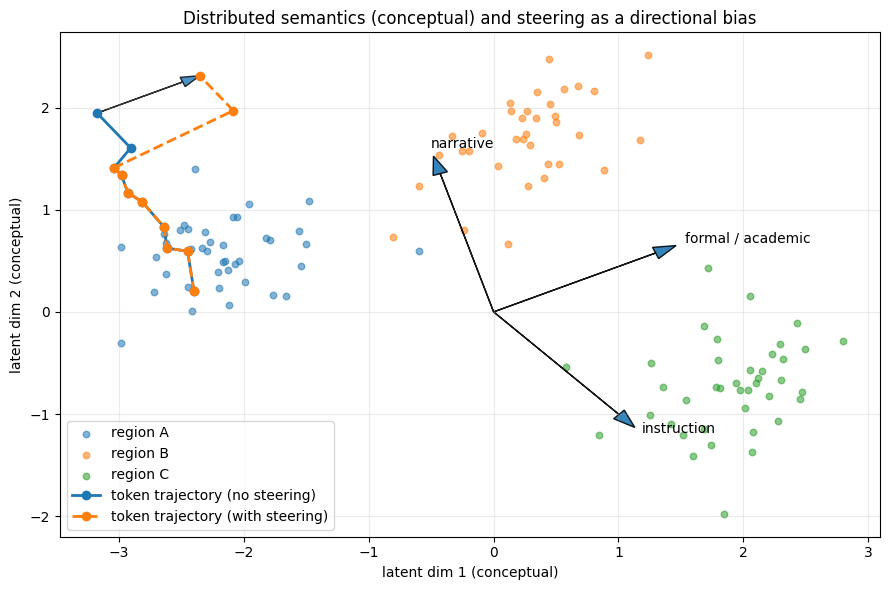

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def make_distributed_semantics_figure(seed=0, savepath=None):
    rng = np.random.default_rng(seed)

    # --- 1) Créer quelques "régions sémantiques" fictives (clusters)
    centers = np.array([
        [-2.2,  0.6],   # région A
        [ 0.2,  1.7],   # région B
        [ 1.8, -0.8],   # région C
    ])
    n_per = [40, 35, 40]
    clouds = []
    labels = []
    for i, (c, n) in enumerate(zip(centers, n_per)):
        cov = np.array([[0.25, 0.05],[0.05, 0.18]])
        pts = rng.multivariate_normal(mean=c, cov=cov, size=n)
        clouds.append(pts)
        labels.append(f"region {chr(ord('A')+i)}")

    # --- 2) Directions "sémantiques" fictives (vecteurs)
    # (angles choisis arbitrairement)
    directions = {
        "formal / academic": np.array([0.9,  0.4]),
        "narrative":         np.array([-0.3, 0.95]),
        "instruction":       np.array([0.7, -0.7]),
    }
    # Normalise pour des flèches comparables
    directions = {k: v / (np.linalg.norm(v) + 1e-9) for k, v in directions.items()}

    # --- 3) Une "trajectoire de token" à travers des couches (fictive)
    # On simule une trajectoire qui se stabilise puis est "steered" à la fin.
    L = 10  # nombre d'étapes/couches fictives
    traj = np.zeros((L, 2))
    traj[0] = np.array([-2.4, 0.2])  # départ (embedding-ish)

    for t in range(1, L):
        # déplacement naturel: vers une zone plus "cohérente"
        drift = 0.35 * directions["narrative"] + 0.15 * rng.normal(size=2)
        # stabilisation: drift diminue au milieu
        scale = 1.0 if t < 3 else (0.55 if t < 7 else 0.8)
        traj[t] = traj[t-1] + scale * drift

    # --- 4) Steering appliqué aux dernières étapes
    steer_dir = directions["formal / academic"]
    steer_strength = 0.9
    steered_traj = traj.copy()
    steered_traj[-2:] = steered_traj[-2:] + steer_strength * steer_dir

    # --- Plot
    plt.figure(figsize=(9, 6))

    # Nuages (tokens fictifs)
    for pts, name in zip(clouds, labels):
        plt.scatter(pts[:, 0], pts[:, 1], s=22, alpha=0.55, label=name)

    # Directions (flèches)
    origin = np.array([0.0, 0.0])
    arrow_len = 1.6
    for name, v in directions.items():
        plt.arrow(origin[0], origin[1], arrow_len*v[0], arrow_len*v[1],
                  length_includes_head=True, head_width=0.12, alpha=0.9)
        plt.text(arrow_len*v[0]*1.05, arrow_len*v[1]*1.05, name, fontsize=10)

    # Trajectoires (avant / après steering)
    plt.plot(traj[:, 0], traj[:, 1], marker="o", linewidth=2, label="token trajectory (no steering)")
    plt.plot(steered_traj[:, 0], steered_traj[:, 1], marker="o", linewidth=2, linestyle="--",
             label="token trajectory (with steering)")

    # Mettre en évidence l'effet steering final
    plt.arrow(traj[-1, 0], traj[-1, 1],
              (steered_traj[-1, 0] - traj[-1, 0]),
              (steered_traj[-1, 1] - traj[-1, 1]),
              length_includes_head=True, head_width=0.10, alpha=0.8)

    plt.title("Distributed semantics (conceptual) and steering as a directional bias")
    plt.xlabel("latent dim 1 (conceptual)")
    plt.ylabel("latent dim 2 (conceptual)")
    plt.grid(True, alpha=0.25)
    plt.legend()
    plt.tight_layout()

    if savepath is not None:
        plt.savefig(savepath, dpi=200)
    plt.show()

# Utilisation :
# make_distributed_semantics_figure(seed=1, savepath="distributed_semantics_steering.png")
make_distributed_semantics_figure(seed=1)

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from typing import Tuple, List, Dict

# -----------------------------
# 1) Utilitaires de filtrage tokens
# -----------------------------

def default_keep_token(token: str) -> bool:
    """
    Heuristique simple :
    - exclut tokens spéciaux HF (souvent "<|...|>" ou "<s>" "</s>")
    - exclut tokens de contrôle type "▁" seuls / espaces purs
    - garde le reste (y compris ponctuation)
    """
    if token is None:
        return False
    t = token.strip()

    # tokens spéciaux / contrôle (Llama chat template etc.)
    if token.startswith("<|") and token.endswith("|>"):
        return False
    if token in {"<s>", "</s>", "<pad>", "<unk>"}:
        return False

    # parfois des tokens vides / espaces
    if t == "":
        return False

    return True


def build_keep_mask(tokens: List[str], attention_mask: torch.Tensor) -> torch.Tensor:
    """
    tokens: list length S
    attention_mask: (S,) bool/int
    return keep_mask: (S,) bool
    """
    attn = attention_mask.bool().cpu()
    keep = torch.tensor([default_keep_token(tok) for tok in tokens], dtype=torch.bool)
    return attn & keep

@torch.no_grad()
def encode_with_user_mask(tokenizer, messages, device="cuda"):
    # Encodage 100% aligné sur le chat template
    enc = tokenizer.apply_chat_template(
        messages,
        tokenize=True,
        return_tensors="pt",
        return_dict=True,
        add_generation_prompt=False,
    )
    input_ids = enc["input_ids"][0].to(device)          # (S,)
    attention_mask = enc["attention_mask"][0].to(device)

    # Pour trouver le début du contenu user, on tokenise la même chose avec user content vide
    msgs_user_empty = []
    for m in messages:
        if m["role"] == "user":
            msgs_user_empty.append({"role": "user", "content": ""})
        else:
            msgs_user_empty.append(m)

    enc_prefix = tokenizer.apply_chat_template(
        msgs_user_empty,
        tokenize=True,
        return_tensors="pt",
        return_dict=True,
        add_generation_prompt=False,
    )
    prefix_ids = enc_prefix["input_ids"][0]
    start = prefix_ids.shape[0]

    # Fin = premier <|eot_id|> après start
    eot_id = tokenizer.convert_tokens_to_ids("<|eot_id|>")
    if eot_id is None or eot_id < 0:
        # fallback Llama3 courant
        eot_id = 128009

    after = input_ids[start:]
    eot_pos = (after == eot_id).nonzero(as_tuple=False)
    if eot_pos.numel() == 0:
        raise RuntimeError("Impossible de trouver <|eot_id|> après le début du user. Template inattendu ?")

    end = start + int(eot_pos[0].item())

    user_mask = torch.zeros_like(input_ids, dtype=torch.bool)
    user_mask[start:end] = True

    tokens = tokenizer.convert_ids_to_tokens(input_ids.tolist())
    return input_ids, attention_mask, user_mask, tokens, (start, end)


# -----------------------------
# 2) Récupération hidden states token-level
# -----------------------------

@torch.no_grad()
def get_hidden_states_for_text(model, tokenizer, text: str, device="cuda", max_tokens: int = 256):
    enc = tokenizer(
        text,
        truncation=True,
        max_length=max_tokens,
        return_tensors="pt",
        add_special_tokens=True,
    )
    input_ids = enc["input_ids"].to(device)
    attention_mask = enc["attention_mask"].to(device)

    out = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        output_hidden_states=True,
        return_dict=True,
        use_cache=False,
    )

    # out.hidden_states: list length (L+1), each (B, S, D)
    hs = torch.stack(out.hidden_states, dim=0)[:, 0]  # (L+1, S, D)
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0].tolist())
    return hs, tokens, attention_mask[0]


# -----------------------------
# 3) Drift metrics : L2 et cosine
# -----------------------------

def layerwise_drift_l2(hs: torch.Tensor) -> torch.Tensor:
    """
    hs: (L+1, S, D)
    returns drift: (L, S) where drift[l-1] = ||hs[l] - hs[l-1]||_2
    """
    diff = hs[1:] - hs[:-1]                           # (L, S, D)
    drift = torch.linalg.norm(diff, dim=-1)           # (L, S)
    return drift


def layerwise_drift_cosine(hs: torch.Tensor, eps: float = 1e-8) -> torch.Tensor:
    """
    cosine drift = 1 - cosine_similarity(h_l, h_{l-1})
    hs: (L+1, S, D)
    returns: (L, S)
    """
    a = hs[1:]   # (L, S, D)
    b = hs[:-1]  # (L, S, D)

    # normalize
    a_norm = a / (torch.linalg.norm(a, dim=-1, keepdim=True) + eps)
    b_norm = b / (torch.linalg.norm(b, dim=-1, keepdim=True) + eps)

    cos = (a_norm * b_norm).sum(dim=-1)              # (L, S)
    return 1.0 - cos


# -----------------------------
# 4) Stats robustes : médiane + IQR
# -----------------------------

def median_iqr(curve_matrix: torch.Tensor) -> Dict[str, np.ndarray]:
    """
    curve_matrix: (L, N_tokens_kept)
    returns dict of numpy arrays length L: median, q25, q75, mean (optionnel)
    """
    x = curve_matrix.cpu().float()
    median = torch.quantile(x, 0.50, dim=1)
    q25    = torch.quantile(x, 0.25, dim=1)
    q75    = torch.quantile(x, 0.75, dim=1)
    mean   = x.mean(dim=1)
    return {
        "median": median.numpy(),
        "q25": q25.numpy(),
        "q75": q75.numpy(),
        "mean": mean.numpy()
    }


# -----------------------------
# 5) Plot : médiane + IQR
# -----------------------------

def plot_layerwise_drift(stats: Dict[str, np.ndarray], title: str, ylabel: str):
    L = len(stats["median"])
    layers = np.arange(1, L + 1)  # drift entre (0->1) est index 1, etc.

    plt.figure(figsize=(9, 5))
    plt.plot(layers, stats["median"], label="median")
    plt.fill_between(layers, stats["q25"], stats["q75"], alpha=0.2, label="IQR (25–75%)")
    # optionnel :
    # plt.plot(layers, stats["mean"], linestyle="--", label="mean")

    plt.title(title)
    plt.xlabel("Layer (difference to previous layer)")
    plt.ylabel(ylabel)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


# -----------------------------
# 6) Pipeline complet : filtrage + drift + plot
# -----------------------------

@torch.no_grad()
def run_token_drift_plots_from_ids(model, tokenizer, input_ids, attention_mask, keep_mask,
                                  drop_embedding_to_layer1=True):
    # batchify
    input_ids_b = input_ids.unsqueeze(0)
    attn_b = attention_mask.unsqueeze(0)

    out = model(
        input_ids=input_ids_b,
        attention_mask=attn_b,
        output_hidden_states=True,
        return_dict=True,
        use_cache=False,
    )

    hs = torch.stack(out.hidden_states, dim=0)[:, 0]  # (L+1, S, D)

    # applique masques : keep_mask + attention_mask
    mask = keep_mask & attention_mask.bool()
    hs_kept = hs[:, mask]  # (L+1, S_kept, D)

    # drift L2 / cosine (tes fonctions)
    drift_l2 = layerwise_drift_l2(hs_kept)
    drift_cos = layerwise_drift_cosine(hs_kept)

    if drop_embedding_to_layer1:
        drift_l2 = drift_l2[1:]
        drift_cos = drift_cos[1:]

    stats_l2 = median_iqr(drift_l2)
    stats_cos = median_iqr(drift_cos)

    plot_layerwise_drift(stats_l2, title="Layer-wise token drift (L2) — USER ONLY", ylabel="L2 distance")
    plot_layerwise_drift(stats_cos, title="Layer-wise token drift (cosine) — USER ONLY", ylabel="1 - cosine similarity")

    kept_tokens = [t for t, k in zip(tokenizer.convert_ids_to_tokens(input_ids.tolist()), mask.cpu().tolist()) if k]
    return {"kept_tokens": kept_tokens, "stats_l2": stats_l2, "stats_cos": stats_cos,
            "drift_l2": drift_l2.cpu(), "drift_cos": drift_cos.cpu()}


messages = [
    {"role": "system", "content": "You are a helpful assistant"},
    {"role": "user", "content": "What is latent space for LLM?"}
]

input_ids, attention_mask, user_mask, tokens, (start, end) = encode_with_user_mask(tokenizer, messages, device=DEVICE)

res = run_token_drift_plots_from_ids(
    model, tokenizer,
    input_ids=input_ids,
    attention_mask=attention_mask,
    keep_mask=user_mask,
    drop_embedding_to_layer1=True
)

print("Span user (start,end):", start, end)
print("Nb tokens gardés:", len(res["kept_tokens"]))
print("Tokens gardés:", res["kept_tokens"])